In [ ]:
import matplotlib.pyplot as plt
# Create labels for the x-axis (temperature ranges)
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import sys
parent_dir = os.path.dirname(os.environ["GTE_DIR"].replace("Glaciation_time_estimator",""))
GTE_DIR=os.environ["GTE_DIR"]
sys.path.insert(0, parent_dir)
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
import seaborn as sns

Load data

In [ ]:
config=read_config(os.path.join(GTE_DIR,'/config_half.yaml'))
t_deltas = config['t_deltas']
agg_fact = config['agg_fact']
min_temp_array, max_temp_array = config['min_temp_arr'],config['max_temp_arr']
folder_name=f"{config['start_time'].strftime(config['time_folder_format'])}_{config['end_time'].strftime(config['time_folder_format'])}"

In [41]:
ice_cont_crit_frac=0.05

In [42]:
def Extract_array_from_df(series:pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)

In [43]:

# Initialize an empty list to store the individual dataframes
cloud_properties_df_list = []

# Iterate over each temperature range
for i in range(len(min_temp_array)):
    cloud_properties_df_list.append([])
    min_temp = min_temp_array[i]
    max_temp = max_temp_array[i]
    
    # Iterate over each pole
    for pole in config["pole_folders"]:
        # Construct the file path
        fp = os.path.join(
            config['postprocessing_output_dir'],
            pole,
            folder_name,
            f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet"
        )
        
        # Read the parquet file into a dataframe
        df = pd.read_parquet(fp)
        
        # Add columns for min_temp, max_temp, and pole
        df['min_temp'] = min_temp
        df['max_temp'] = max_temp
        df['pole'] = pole
        df['Hemisphere'] = "South" if pole == "sp" else "North"
        df['Lifetime [h]'] = df['track_length'] / pd.Timedelta(hours=1)
        
        # Append the dataframe to the sublist
        cloud_properties_df_list[i].append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat([df for sublist in cloud_properties_df_list for df in sublist], ignore_index=True)

In [44]:
def normalize_IF_hist(row):
    lst = row['ice_frac_hist']
    normalized_length = 100
    original_indices = np.linspace(0, 1, len(lst))
    target_indices = np.linspace(0, 1, normalized_length)
    return np.interp(target_indices, original_indices, lst)

def max_normalize_IF_hist(row):
    lst = row['ice_frac_hist']
    max_val = np.max(lst)
    normalized_length=100
    if max_val == 0:
        normalized_list = np.zeros(normalized_length)
        max_idx = None
    else:
        max_idx = np.argmax(lst)
        original_indices = np.linspace(0, max_idx, len(lst[:max_idx + 1]))
        target_indices = np.linspace(0, max_idx, normalized_length)
        normalized_list = np.interp(target_indices, original_indices, lst[:max_idx + 1])
        normalized_list = np.pad(normalized_list, (0, normalized_length - len(normalized_list)), constant_values=np.nan)
    return normalized_list, max_idx

In [45]:
norm_IF_hist_list= []
max_norm_IF_hist_list =[]
Timesteps_to_max_list= []
for i, row in combined_df.iterrows():
    if i%10000==0:
        print(i/10000)
    max_norm_IF_hist, Timesteps_to_max =max_normalize_IF_hist(row)
    norm_IF_hist_list.append(normalize_IF_hist(row))
    max_norm_IF_hist_list.append(max_norm_IF_hist)
    Timesteps_to_max_list.append(Timesteps_to_max)
combined_df["Timesteps_to_max"] = Timesteps_to_max_list
combined_df['max_norm_IF_hist'] = max_norm_IF_hist_list
combined_df['norm_IF_hist'] = norm_IF_hist_list

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0


Load data

In [46]:
def Extract_array_from_df(series:pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)

In [47]:
cloud_properties_df_list=[]
for i in range(len(min_temp_array)):
    cloud_properties_df_list.append([])
    min_temp=min_temp_array[i]
    max_temp=max_temp_array[i]
    for pole in config["pole_folders"]:
        fp=os.path.join(config['postprocessing_output_dir'],pole,folder_name,f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet")
        cloud_properties_df_list[i].append(pd.read_parquet(fp))

Spaghetti plots

In [48]:
def check_cloud(row, params):
    norm_ice_frac_hist = row['norm_IF_hist']
    if (max(norm_ice_frac_hist) >=params['crit_max_IF']) and row['Timesteps_to_max'] >=params['min_time_to_max'] and row['track_length']>=params['crit_lifetime'] and (max(norm_ice_frac_hist) >= norm_ice_frac_hist[:10].mean()+params['min_delta_IF']):
        return True
    return False



In [49]:
sample_df = combined_df.sample(10,random_state = 0)

In [50]:
sample_df["Lifetime [h]"].idxmax()

229152

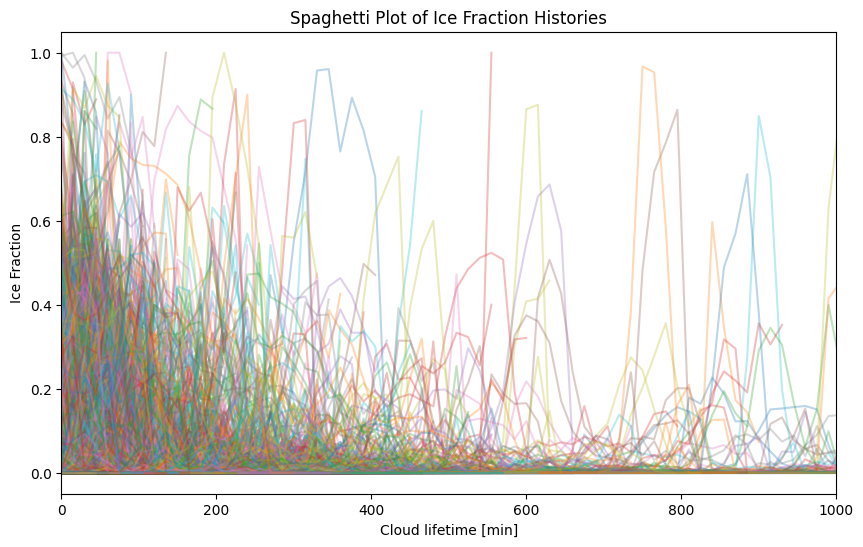

In [71]:
# Create the figure and axis
plt.figure(figsize=(10, 6))

# Loop through each row and plot the lists in 'ice_frac_hist'
for i, row in cloud_properties_df_list[1][1].iterrows():
    ice_frac_hist = row['ice_frac_hist']
    plt.plot(np.arange(len(ice_frac_hist))*15, ice_frac_hist, alpha=0.3)  # Add alpha for transparency to better visualize overlaps

# Add labels and title
plt.xlabel('Cloud lifetime [min]')
plt.ylabel('Ice Fraction')
plt.title('Spaghetti Plot of Ice Fraction Histories')
plt.xlim(0,1000)
# Show the plot
plt.show()

KeyboardInterrupt: 

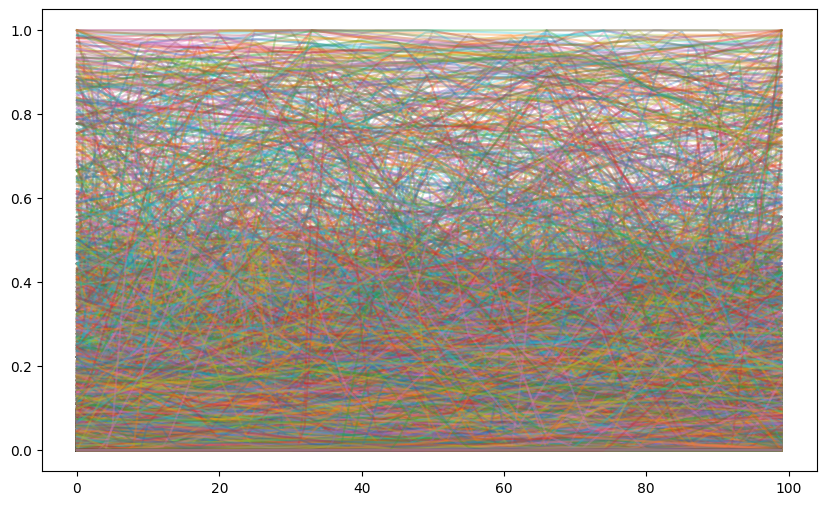

In [ ]:

# Assuming your DataFrame is named df and the column with lists is 'ice_frac_hist'
plt.figure(figsize=(10, 6))

# Iterate through the list of DataFrames
for df_ind in range(len(cloud_properties_df_list)):
    df = cloud_properties_df_list[df_ind][1]

    # Determine the number of points to normalize to (e.g., 100 points for percentages)
    normalized_length = 100

    # Normalize each list to the same length using interpolation
    normalized_ice_frac_hist = []
    for lst in df['ice_frac_hist']:
        original_indices = np.linspace(0, 1, len(lst))
        target_indices = np.linspace(0, 1, normalized_length)
        normalized_list = np.interp(target_indices, original_indices, lst)
        normalized_ice_frac_hist.append(normalized_list)

    df['normalized_ice_frac_hist'] = normalized_ice_frac_hist

    # Define a color for this DataFrame based on its index
    color = plt.cm.rainbow(df_ind / len(cloud_properties_df_list))

    # Loop through each row and plot the normalized lists in 'normalized_ice_frac_hist'
    for i, row in df.iterrows():
        ice_frac_hist = row['normalized_ice_frac_hist']
        plt.plot(range(len(ice_frac_hist)), ice_frac_hist, alpha=0.3)  # Add alpha for transparency and color coding

# Add labels, title, and color bar
# sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=len(cloud_properties_df_list)))
# cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)
# cbar.set_label('Temperature range')
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.xlabel('Percentage of Original Length')
plt.ylabel('Ice Fraction')
plt.title('Spaghetti Plot of Length-Normalized Ice Fraction Histories')

# Save the plot
filename = os.path.join(GTE_DIR,"/Result_graphs/Spaghetti_plot_normalized_lifetime1")
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)

# Show the plot
plt.show()

0
54430


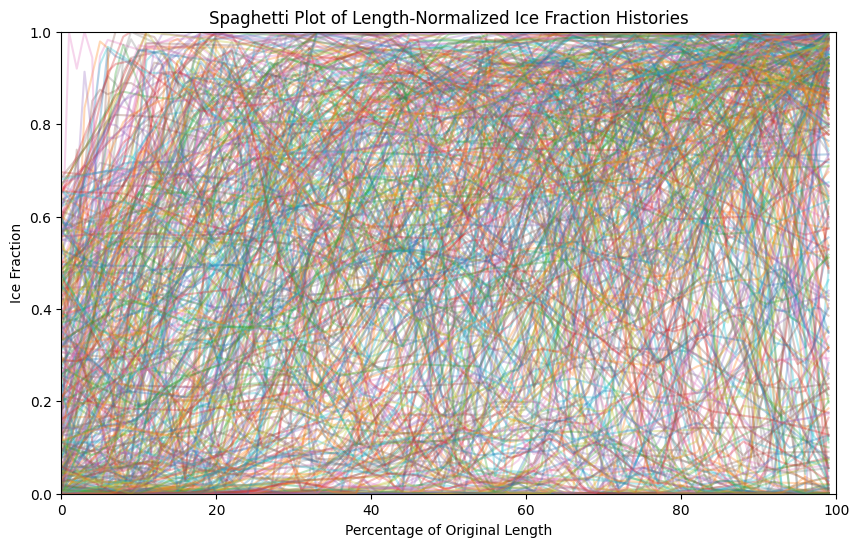

In [ ]:
# Assuming your DataFrame is named df and the column with lists is 'ice_frac_hist'
plt.figure(figsize=(10, 6))
err_count=0
count = 0
for df_ind in range(len(cloud_properties_df_list)):
    df = cloud_properties_df_list[df_ind][1]
    # Assuming your DataFrame is named df and the column with lists is 'ice_frac_hist'

    # Determine the number of points to normalize to (e.g., 100 points for percentages)
    normalized_length = 100

    # Normalize each list to the same length using interpolation
    normalized_ice_frac_hist = []
    for lst in df['ice_frac_hist']:
        original_indices = np.linspace(0, 1, len(lst))
        target_indices = np.linspace(0, 1, normalized_length)
        normalized_list = np.interp(target_indices, original_indices, lst)
        normalized_ice_frac_hist.append(normalized_list)

    df['normalized_ice_frac_hist'] = normalized_ice_frac_hist

    # Create the figure and axis
    

    # Loop through each row and plot the normalized lists in 'normalized_ice_frac_hist'
    for i, row in df.iterrows():
        ice_frac_hist = row['normalized_ice_frac_hist']
        count+=1
        if len(row['ice_frac_hist'])-1 != int(row['track_length']/timedelta(minutes=15)):
            err_count+=1
            print(len(row['ice_frac_hist']) , row['track_length']/timedelta(minutes=15))
        if row['track_length']>timedelta(hours=2):
            if max(ice_frac_hist) > 0.3:
                if max(ice_frac_hist) > ice_frac_hist[0]+0.3:
                    if max(ice_frac_hist) > 0.9:
                        plt.plot(range(len(ice_frac_hist)), ice_frac_hist, alpha=0.3)  # Add alpha for transparency to better visualize overlaps
print(err_count)
print(count)
# Add labels and title
plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel('Percentage of Original Length')
plt.ylabel('Ice Fraction')
plt.title('Spaghetti Plot of Length-Normalized Ice Fraction Histories')
filename=os.path.join(GTE_DIR,"/Result_graphs/Spaghetti_plot_normalized_lifetime2")
plt.savefig(filename+".pdf", dpi=400)
plt.savefig(filename+".png", dpi=400)
# Show the plot
plt.show()


In [ ]:
def check_cloud(row, params):   
    norm_ice_frac_hist = row['normalized_ice_frac_hist']
    if (max(norm_ice_frac_hist) > params['crit_max_IF']) and np.argmax(np.array(row['ice_frac_hist']))+1>=params['min_time_to_max'] and row['track_length']>params['crit_lifetime'] and (max(norm_ice_frac_hist) > ice_frac_hist[0]+params['min_delta_IF']):
        return True
    return False

params = {
    'crit_max_IF': 0.5,
    'crit_lifetime': timedelta(hours=2),
    'min_delta_IF': 0.3,
    'min_time_to_max': 4
}
    

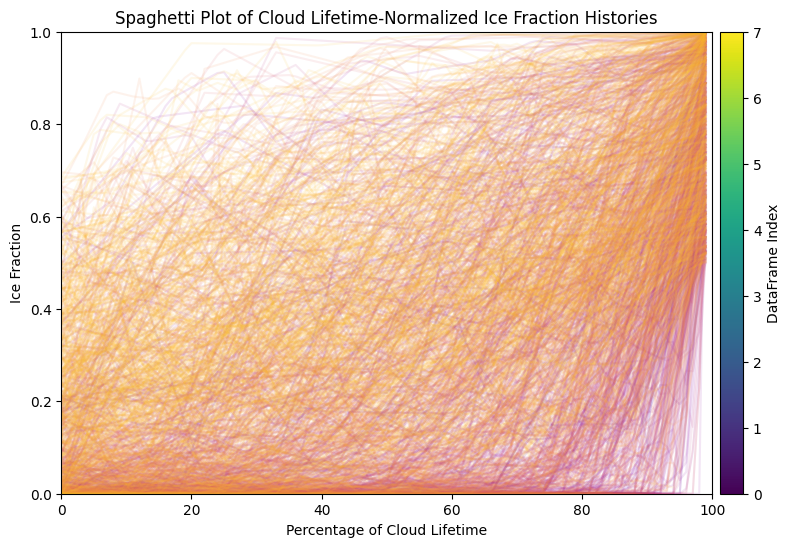

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named df and the column with lists is 'ice_frac_hist'
plt.figure(figsize=(10, 6))

# Iterate through the list of DataFrames
for df_ind in range(len(cloud_properties_df_list)):
    df = cloud_properties_df_list[df_ind][1]

    # Determine the number of points to normalize to (e.g., 100 points for percentages)
    normalized_length = 100

    # Normalize each list between its start and its maximum value
    normalized_ice_frac_hist = []
    rapid_growth = []
    for lst in df['ice_frac_hist']:
        max_val = np.max(lst)
        if max_val == 0:
            normalized_list = np.zeros(normalized_length)
            rapid_growth.append(False)
        else:
            max_idx = np.argmax(lst)
            original_indices = np.linspace(0, max_idx, len(lst[:max_idx + 1]))
            target_indices = np.linspace(0, max_idx, normalized_length)
            normalized_list = np.interp(target_indices, original_indices, lst[:max_idx + 1])
            normalized_list = np.pad(normalized_list, (0, normalized_length - len(normalized_list)), constant_values=np.nan)

            # Mark as False if the maximum is reached in less than 4 timesteps
            rapid_growth.append(max_idx + 1 >= 4)

        normalized_ice_frac_hist.append(normalized_list)

    df['normalized_ice_frac_hist'] = normalized_ice_frac_hist
    df['rapid_growth'] = rapid_growth

    # Define a color for this DataFrame based on its index
    color = plt.cm.plasma(df_ind / len(cloud_properties_df_list))

    # Loop through each row and plot the normalized lists in 'normalized_ice_frac_hist'
    for i, row in df.iterrows():
        if check_cloud(row):
            ice_frac_hist = row['normalized_ice_frac_hist']
            plt.plot(range(len(ice_frac_hist)), ice_frac_hist, alpha=0.1, color=color)  # Add alpha for transparency and color coding

# Add labels, title, and color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=len(cloud_properties_df_list)))
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)
cbar.set_label('DataFrame Index')
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.xlabel('Percentage of Cloud Lifetime')
plt.ylabel('Ice Fraction')
plt.title('Spaghetti Plot of Cloud Lifetime-Normalized Ice Fraction Histories')

# Save the plot
filename = os.path.join(GTE_DIR,"/Result_graphs/Spaghetti_plot_normalized_lifetime3")
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)

# Show the plot
plt.show()
